In [1]:
# Upgrade Oracle ADS

!pip install -U oracle-ads

<font color=gray>Oracle Data Science service sample notebook.

Copyright (c) 2023 Oracle, Inc.  All rights reserved.
Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl.
</font>

***
# <font color=red>Sklearn으로 모델 만들기</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle Cloud Infrastructure Data Science Service Team </font></p>

***

## Introduction:

NLP 분석을 수행하는 데에는 다양한 목적이 있습니다. 텍스트 본문의 유사성을 다른 텍스트 본문과 비교할 수도 있고(클러스터링 기술/거리 측정) 텍스트 본문을 구성하는 주제를 찾을 수도 있습니다. 

이 노트북에서는 Oracle Livelabs를 크롤링한 데이터 세트로 Topic Modeling(주제 모델링)을 진행합니다.Topic Modeling(주제 모델링)은 기본 문서 및 텍스트 코퍼스의 단어를 기반으로 "주제"를 밝히려는 프로세스입니다. 

여기서는 LDA(Latent Dirichlet Allocation)로 알려진 주제 모델링 기술을 소개합니다. 또한 학습 모델로 예측할 때 유용할 원시 텍스트의 토큰화, 형태소 분석 및 벡터화와 같은 몇 가지 자연어 처리 기본 사항도 소개합니다. 

--- 

## Overview:
이 노트북의 개요는 다음과 같습니다.

- 1. 분석에 맞는 형태로 불필요한 데이터를 없애고 적합한 형태로 변형

- 2. **NLTK(Natural Language Toolkit)를 사용한 자연어 처리(NLP)** - 용어 빈도(TF) 및 역 문서 빈도를 통한 토큰화, 불용어 제거, 형태소 분석 및 텍스트 벡터화와 같은 기본 텍스트 처리 방법 소개 (COUNT Vectorizer)

- 3. **LDA를 사용한 토픽 모델링** - LDA(Latent Dirichlet Allocation) 토픽 모델링 기법을 구현합니다.

- 4. **KMeans를 사용한 클러스터링** - LDA를 통해 Topic별 추출된 probability를 feature로 각 livelab을 비슷한 군집끼리 묶어봅니다.

---

In [2]:
# 필요 라이브러리 Import

import ocifs
import oci
from ocifs import OCIFileSystem

import json
import base64
import numpy as np
import pandas as pd

import ads
from dask import dataframe as ddf

# 1. 데이터 로드 및 Data Cleansing

Bucket에 있는 크롤링 데이터(json) 로드하고 한국어 레코드 삭제

## 1) ATP에서 데이터 로딩

In [3]:
# ATP에서 crawled 데이터 로딩 
# If you are using Wallet file, provide the zip file path for `wallet_location`

connection_parameters = {
    "user_name": "admin",
    "password": "Welcome123456!",
    "service_name": "twdemo_low",
    "wallet_location": "./wallet/Wallet_twdemo.zip",
}

In [4]:
import pandas as pd
import ads

df = pd.DataFrame.ads.read_sql(
    "SELECT * FROM DEMO",
    connection_parameters=connection_parameters,
)

df = pd.DataFrame.ads.read_sql(
    """
    SELECT
    *
    FROM
    DEMO
    """,
    connection_parameters=connection_parameters,
)

ERROR - Exception
Traceback (most recent call last):
  File "/home/datascience/conda/naturallanguageprocessingforcpupython3_7v2_0/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_22375/3214112986.py", line 6, in <module>
    connection_parameters=connection_parameters,
  File "/home/datascience/conda/naturallanguageprocessingforcpupython3_7v2_0/lib/python3.7/site-packages/ads/dbmixin/db_pandas_accessor.py", line 94, in read_sql
    return Connection(**connection_parameters).query(
  File "/home/datascience/conda/naturallanguageprocessingforcpupython3_7v2_0/lib/python3.7/site-packages/ads/oracledb/oracle_db.py", line 111, in __init__
    super().__init__(**kwargs)
cx_Oracle.DatabaseError: ORA-12514: TNS:listener does not currently know of service requested in connect descriptor
DatabaseError: ORA-12514: TNS:listener does not currently know of service requested in connect des

In [ ]:
df

## 2) Object Storage에서 데이터 로딩

In [4]:
# Bucket에 있는 크롤링 데이터 import

crawled_parquet_df = pd.read_json("oci://crawled_data@apackrsct01/data_20230307.json")
crawled_parquet_df.head()

,id,title,url,type,desc,duration,crawled_time,title_ko,desc_ko,duration_ko,oci_products,key_phrase
0,553,Manage and Monitor Autonomous Database,https://apexapps.oracle.com/pls/apex/r/dbpm/li...,Hands-on,The labs in this workshop show you a variety o...,3 hours,2023-03-07 07:18:57,Autonomous Database 관리 및 모니터링,이 워크샵의 실습에서는 Oracle Autonomous Database on Sha...,3시간,"[adb-s, refreshable database]","[variety of ways, oracle autonomous database, ..."
1,554,Low Code Development Oracle APEX on Autonomous...,https://apexapps.oracle.com/pls/apex/r/dbpm/li...,Hands-on,"Using APEX, developers can quickly develop and...",2 hours,2023-03-07 07:19:10,Autonomous Database의 로우 코드 개발 Oracle APEX,개발자는 APEX를 사용하여 실제 문제를 해결하고 즉각적인 가치를 제공하는 강력한 ...,2시간,"[apps, apex, oracle apex]","[autonomous databaseusing apex, compelling app..."
2,560,Machine Learning on Autonomous Database,https://apexapps.oracle.com/pls/apex/r/dbpm/li...,Hands-on,Oracle integrates machine learning across the ...,2 hours,2023-03-07 07:19:32,Autonomous Database의 머신 러닝,Oracle은 Oracle Database와 Oracle Autonomous Dat...,2시간,"[applications, machine learning notebooks, adb]","[machine learning, autonomous databaseoracle i..."
3,566,Boost Analytics Performance with Oracle Databa...,https://apexapps.oracle.com/pls/apex/r/dbpm/li...,Hands-on,Oracle Database In-Memory provides a unique du...,"1 hour, 30 minutes",2023-03-07 07:19:47,Oracle Database In-Memory를 통한 분석 성능 향상,Oracle Database In-Memory는 기존의 행 형식과 새로운 in-me...,1시간 30분,[im],"[oracle database 21c, database in-memory, im c..."
4,567,Oracle WebLogic Server Kubernetes Operator Tut...,https://apexapps.oracle.com/pls/apex/r/dbpm/li...,Hands-on,This workshop provides the process of moving a...,1 hour,2023-03-07 07:19:52,Oracle WebLogic Server Kubernetes Operator 자습서,이 워크샵은 기존 WebLogic 서버 애플리케이션을 Oracle Public Cl...,1시간,"[weblogic server application, oracle weblogic ...","[existing weblogic server application, kuberne..."


In [5]:
# 한국어 레코드 확인

print (crawled_parquet_df.loc[crawled_parquet_df['id'] == 3206])

       id                                              title  \
466  3206  [Korean] Oracle Container for Kubernetes Funda...   

                                                   url      type  \
466  https://apexapps.oracle.com/pls/apex/r/dbpm/li...  Hands-on   

                                                  desc duration  \
466  이 워크샵을 통해, 여러분은 마이크로서비스를 개발하고, 쿠버네티스에 배포하는 방법을...  4 hours   

           crawled_time                                  title_ko  \
466 2023-03-07 08:36:25  [한국어] Oracle Container for Kubernetes 기초   

                                               desc_ko duration_ko  \
466  2014년 1월 20일에 확인함. ↑ 가 나 다 라 마 바 사 아 바 사 아 사 아...         4시간   

    oci_products                                         key_phrase  
466          NaN  [oracle container, kubernetes fundamentals��� ...  


In [6]:
crawled_parquet_df.loc[466]

id                                                           3206
title           [Korean] Oracle Container for Kubernetes Funda...
url             https://apexapps.oracle.com/pls/apex/r/dbpm/li...
type                                                     Hands-on
desc            이 워크샵을 통해, 여러분은 마이크로서비스를 개발하고, 쿠버네티스에 배포하는 방법을...
duration                                                  4 hours
crawled_time                                  2023-03-07 08:36:25
title_ko                 [한국어] Oracle Container for Kubernetes 기초
desc_ko         2014년 1월 20일에 확인함. ↑ 가 나 다 라 마 바 사 아 바 사 아 사 아...
duration_ko                                                   4시간
oci_products                                                  NaN
key_phrase      [oracle container, kubernetes fundamentals��� ...
Name: 466, dtype: object

In [7]:
print (crawled_parquet_df.loc[crawled_parquet_df['id'] == 3598])

       id                                title  \
772  3598  [Korean] OCI Functions Fundamentals   

                                                   url      type  \
772  https://apexapps.oracle.com/pls/apex/r/dbpm/li...  Hands-on   

                                                  desc duration  \
772  After this workshop, you will know the fundame...  4 hours   

           crawled_time                title_ko  \
772 2023-03-07 08:58:43  [한국어] OCI Functions 기초   

                                               desc_ko duration_ko  \
772  이 워크샵을 마치면 OCI Functions의 기본 사항과 고객의 요구 사항을 지원...         4시간   

    oci_products                                         key_phrase  
772        [oci]  [oci functions fundamentalsafter, fundamentals...  


In [8]:
crawled_parquet_df.loc[772]

id                                                           3598
title                         [Korean] OCI Functions Fundamentals
url             https://apexapps.oracle.com/pls/apex/r/dbpm/li...
type                                                     Hands-on
desc            After this workshop, you will know the fundame...
duration                                                  4 hours
crawled_time                                  2023-03-07 08:58:43
title_ko                                   [한국어] OCI Functions 기초
desc_ko         이 워크샵을 마치면 OCI Functions의 기본 사항과 고객의 요구 사항을 지원...
duration_ko                                                   4시간
oci_products                                                [oci]
key_phrase      [oci functions fundamentalsafter, fundamentals...
Name: 772, dtype: object

In [9]:
# 테스트 데이터 확인

print (crawled_parquet_df.loc[crawled_parquet_df['id'] == 1065])

       id                    title  \
404  1065  William Test - Unlisted   

                                                   url      type  desc  \
404  https://apexapps.oracle.com/pls/apex/r/dbpm/li...  Hands-on  test   

    duration        crawled_time            title_ko desc_ko duration_ko  \
404   1 hour 2023-03-07 07:53:20  William Test - 미등록     테스트         1시간   

    oci_products                    key_phrase  
404          NaN  [william test, unlistedtest]  


In [10]:
crawled_parquet_df.loc[404]

id                                                           1065
title                                     William Test - Unlisted
url             https://apexapps.oracle.com/pls/apex/r/dbpm/li...
type                                                     Hands-on
desc                                                         test
duration                                                   1 hour
crawled_time                                  2023-03-07 07:53:20
title_ko                                       William Test - 미등록
desc_ko                                                       테스트
duration_ko                                                   1시간
oci_products                                                  NaN
key_phrase                           [william test, unlistedtest]
Name: 404, dtype: object

In [11]:
# 테스트 데이터 확인

print (crawled_parquet_df.loc[crawled_parquet_df['id'] == 3095])

       id                                     title  \
412  3095  Testing WMS-LL ORDS Sync - Please Ignore   

                                                   url      type  \
412  https://apexapps.oracle.com/pls/apex/r/dbpm/li...  Hands-on   

              desc duration        crawled_time  \
412  override long          2023-03-07 08:32:04   

                            title_ko  desc_ko duration_ko oci_products  \
412  WMS-LL ORDS 동기화 테스트 중 - 무시하십시오.  long 대체         NaN          NaN   

                     key_phrase  
412  [testing wms-ll ords sync]  


In [12]:
crawled_parquet_df.loc[412]

id                                                           3095
title                    Testing WMS-LL ORDS Sync - Please Ignore
url             https://apexapps.oracle.com/pls/apex/r/dbpm/li...
type                                                     Hands-on
desc                                                override long
duration                                                         
crawled_time                                  2023-03-07 08:32:04
title_ko                          WMS-LL ORDS 동기화 테스트 중 - 무시하십시오.
desc_ko                                                   long 대체
duration_ko                                                   NaN
oci_products                                                  NaN
key_phrase                             [testing wms-ll ords sync]
Name: 412, dtype: object

In [13]:
#한국어 및 테스트 데이터 삭제 

df_final=crawled_parquet_df.drop([404,412,466,772])

In [14]:
df_final.head()

,id,title,url,type,desc,duration,crawled_time,title_ko,desc_ko,duration_ko,oci_products,key_phrase
0,553,Manage and Monitor Autonomous Database,https://apexapps.oracle.com/pls/apex/r/dbpm/li...,Hands-on,The labs in this workshop show you a variety o...,3 hours,2023-03-07 07:18:57,Autonomous Database 관리 및 모니터링,이 워크샵의 실습에서는 Oracle Autonomous Database on Sha...,3시간,"[adb-s, refreshable database]","[variety of ways, oracle autonomous database, ..."
1,554,Low Code Development Oracle APEX on Autonomous...,https://apexapps.oracle.com/pls/apex/r/dbpm/li...,Hands-on,"Using APEX, developers can quickly develop and...",2 hours,2023-03-07 07:19:10,Autonomous Database의 로우 코드 개발 Oracle APEX,개발자는 APEX를 사용하여 실제 문제를 해결하고 즉각적인 가치를 제공하는 강력한 ...,2시간,"[apps, apex, oracle apex]","[autonomous databaseusing apex, compelling app..."
2,560,Machine Learning on Autonomous Database,https://apexapps.oracle.com/pls/apex/r/dbpm/li...,Hands-on,Oracle integrates machine learning across the ...,2 hours,2023-03-07 07:19:32,Autonomous Database의 머신 러닝,Oracle은 Oracle Database와 Oracle Autonomous Dat...,2시간,"[applications, machine learning notebooks, adb]","[machine learning, autonomous databaseoracle i..."
3,566,Boost Analytics Performance with Oracle Databa...,https://apexapps.oracle.com/pls/apex/r/dbpm/li...,Hands-on,Oracle Database In-Memory provides a unique du...,"1 hour, 30 minutes",2023-03-07 07:19:47,Oracle Database In-Memory를 통한 분석 성능 향상,Oracle Database In-Memory는 기존의 행 형식과 새로운 in-me...,1시간 30분,[im],"[oracle database 21c, database in-memory, im c..."
4,567,Oracle WebLogic Server Kubernetes Operator Tut...,https://apexapps.oracle.com/pls/apex/r/dbpm/li...,Hands-on,This workshop provides the process of moving a...,1 hour,2023-03-07 07:19:52,Oracle WebLogic Server Kubernetes Operator 자습서,이 워크샵은 기존 WebLogic 서버 애플리케이션을 Oracle Public Cl...,1시간,"[weblogic server application, oracle weblogic ...","[existing weblogic server application, kuberne..."


---

# 2. Natural Language Processing(자연어 처리)

자연어 처리를 위해서는 원시 텍스트를 모델과 시스템에서 읽을 수 있는 형식으로 변환하기 위한 몇 가지 사전 처리 단계가 필요합니다. 

1. **Tokenization(토큰화)** - 텍스트를 개별 구성 단어로 분리합니다.
2. **Stopwords(불용어 처리)** - 너무 자주 발생하는 단어는 삭제합니다. 발생 빈도가 관련 텍스트를 감지하는 데 도움이 되지 않습니다.(매우 드물게 발생하는 단어를 버리는 것도 고려하세요).
3. **Stemmization(어간 추출)** - 변형된 단어를 동일한 의미를 전달하는 단일 상위 단어로 결합합니다.
4. **Vectorization(벡터화)** - 텍스트를 벡터 형식으로 변환합니다. 간단한 방식 중 하나는 bag-of-words 접근 방식(단어 빈도 저장)입니다. 

**Natural Language Toolkit(NLTK)**: 자연어 처리 노력을 더욱 편리하게 하기 위해 NLP에서 가장 편리한 도구 키트 중 하나인 Natural Language Toolkit (http://www.nltk.org/)

In [15]:
import nltk

## 2a. Tokenization(토큰화)

토큰화의 개념은 주어진 문서에서 일련의 문자를 취하여 이 방법의 시조 "토큰"인 개별 구성 조각으로 나누는 행위입니다. 

"word_tokenize( )"(TreebankWord 토크나이저)라는 편리한 방법이 있습니다. 이 방법은 단수 단어와 문장 부호를 다음과 같이 자동으로 별도의 요소로 제거합니다.

In [16]:
first_text = df_final.desc[0]
first_text_list = nltk.word_tokenize(first_text)
print(first_text)
print("="*90)
print(first_text_list)

The labs in this workshop show you a variety of ways to manage and monitor your Oracle Autonomous Database on Shared Infrastructure (ADB-S). You will provision a new ADB instance, practice connecting to the database securely with and without a connection wallet, examine a variety of ways to monitor database performance and other metrics, apply scaling and auto scaling, enable disaster recovery using Autonomous Data Guard, create refreshable database clones, set event and alarm notifications, and secure your data using Oracle Data Safe.
['The', 'labs', 'in', 'this', 'workshop', 'show', 'you', 'a', 'variety', 'of', 'ways', 'to', 'manage', 'and', 'monitor', 'your', 'Oracle', 'Autonomous', 'Database', 'on', 'Shared', 'Infrastructure', '(', 'ADB-S', ')', '.', 'You', 'will', 'provision', 'a', 'new', 'ADB', 'instance', ',', 'practice', 'connecting', 'to', 'the', 'database', 'securely', 'with', 'and', 'without', 'a', 'connection', 'wallet', ',', 'examine', 'a', 'variety', 'of', 'ways', 'to', '

## 2b. 불용어 제거

불용어는 학습 또는 예측 프로세스에 실제로 크게 기여하지 않는 말뭉치에서 매우 일반적이고 높은 빈도로 나타나는 단어입니다. 

불용어에는 "to" 또는 "the"와 같은 용어가 포함되어 있으므로 사전 처리 단계에서 이러한 용어를 제거하는 것이 좋습니다. 

편리하게도 NLTK는 사전 정의된 153개의 영어 불용어 목록과 함께 제공됩니다.

In [17]:
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [18]:
first_text_list_cleaned = [word for word in first_text_list if word.lower() not in stopwords]
second_text_list_cleaned = [word.lower() for word in first_text_list_cleaned if word.isalpha()]

print(second_text_list_cleaned)
print("="*90)
print("Length of original list: {0} words\n"
      "Length of list after stopwords removal: {1} words"
      .format(len(first_text_list), len(second_text_list_cleaned)))

['labs', 'workshop', 'show', 'variety', 'ways', 'manage', 'monitor', 'oracle', 'autonomous', 'database', 'shared', 'infrastructure', 'provision', 'new', 'adb', 'instance', 'practice', 'connecting', 'database', 'securely', 'without', 'connection', 'wallet', 'examine', 'variety', 'ways', 'monitor', 'database', 'performance', 'metrics', 'apply', 'scaling', 'auto', 'scaling', 'enable', 'disaster', 'recovery', 'using', 'autonomous', 'data', 'guard', 'create', 'refreshable', 'database', 'clones', 'set', 'event', 'alarm', 'notifications', 'secure', 'data', 'using', 'oracle', 'data', 'safe']
Length of original list: 94 words
Length of list after stopwords removal: 55 words


## 2c. Stemming & Lemmatization(형태소 분석 및 원형 추출)

불용어를 제거한 후 소개하고 싶은 NLP의 다음 단계는 어간 추출 과정입니다. 이 단계에서의 작업은 유사한 단어의 다양한 변형을 단일 용어로 줄이려고 시도합니다(다양한 변형이 모두 단일 단어 *Stem*으로 축소됨). 

예를 들어 "running", "runs" 및 "run"이 있는 경우 이 세 단어가 "run"이라는 단어로 축소시켜야 합니다. Porter, lancaster, Snowball 등 다양한 형태소 분석기를 사용할 수 있습니다. 아래 예시에서는 Porter Stemmer를 사용하였습니다. 

In [19]:
stemmer = nltk.stem.PorterStemmer()
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


stemmer는 위에 주어진 단어를 기본 형식으로 줄였습니다. 이 단계는 텍스트 학습 및 분류 작업을 할 때 단어 데이터 세트의 크기를 줄이는 데 가장 큰 도움이 됩니다. 

그러나 형태소 분석 과정에서는 단어를 축소할 때 어휘 또는 단어 형식을 고려하지 않는다는 단점이 있습니다. 

아래는 leaves의 형태소 분석 결과입니다. leaves의 원형은 leaf이지만 아래의 결과는 leaves의 'es'를 단어의 복수형으로 파악하여 잘못된 원형을 도출한 것을 알 수 있습니다. 

In [20]:
print("The stemmed form of leaves is: {}".format(stemmer.stem("leaves")))

The stemmed form of leaves is: leav


### Lemmatization(어간 추출)

따라서 이를 보완할 수 있는 방법을 사용하는데 이는 lemmatization입니다. Lemmatization은 형태소 분석기와는 달리 실제 사전이나 어휘(Lemma)를 기반으로 단어를 줄이는 것을 목표로 하기 때문에 어휘 의미를 갖지 않는 형태소 형태로 자르지 않습니다. 여기에서 NLTK를 다시 한 번 활용하여 lemmatizer(WordNet 변형)를 초기화하고 다음과 같이 단어를 축소시킬 수 있습니다. 

In [21]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

The lemmatized form of leaves is: leaf


위 예에서 알 수 있듯이 lemmatizer는 단어를 훨씬 더 어휘적으로 이해되는 형식으로 축소하는 것을 볼 수 있습니다.

## 2d. Vectorization(원시 텍스트 벡터화)

위에서 세 가지 단계에 대해 얘기했습니다. 그러나 이 형태는 사람이 읽을 수 있는 형태이지, 기계가 읽을 수 있는 형태는 아닙니다. 기계는 비트와 숫자를 읽을 수 있으므로 먼저 Bag-of-Words로 알려진 매우 일반적인 접근 방식을 활용하여 텍스트를 숫자로 변환해야 합니다.

---

**Bag of Words 접근 방식**

이 접근 방식은 단어 수를 시작 블록으로 사용하고 특정 단어에 특정한 벡터에 각 단어의 빈도를 기록합니다.

예를 들어 "I love to eat Burgers", "I love to eat Fries"라는 두 문장이 주어지면 먼저 토큰화하여 단어 수를 얻을 수 있는 6개 단어의 어휘를 얻습니다.[I, love, to, eat , Burgers, Fries]

Bag of Words 접근 방식을 통해 텍스트를 벡터화하면 각 단어에 대해 6개의 고유한 벡터가 생기고, 각 단어는 이 새로운 변환 데이터 세트에서 개별 기능/열이 됩니다. 

아래 예시를 통해 Scikit-learn 라이브러리를 활용하여 다음과 같이 CountVectorizer 메서드를 통해 단어 수(용어 빈도)의 벡터를 생성하는 벡터화기를 구현합니다.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

sentence = ["I love to eat Burgers", 
            "I love to eat Fries"]
vectorizer = CountVectorizer(min_df=0)
sentence_transform = vectorizer.fit_transform(sentence)

**vectorizer를 데이터 세트에 Fitting**

먼저 "벡터화기"라고 하는 CountVectorizer 함수를 통해 간단한 용어 빈도 객체를 초기화하고 생성합니다. 여기에서 매개변수 "min_df"는 최소 문서 빈도를 나타내며 벡터화기는 해당 값보다 적게 발생하는 모든 단어를 삭제합니다. 이 방법과 사용할 수 있는 나머지 매개변수에 대한 자세한 내용은 [Sklearn 웹사이트](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction을 참조하세요. .text.CountVectorizer.html).

마지막으로 fit_transform 메서드를 적용하는 것은 실제로 두 단계로 구성됩니다. 첫 번째 단계는 벡터라이저가 제공하는 데이터 세트에 매핑되는 방법입니다. 이 작업이 완료되면 아래와 같이 원시 텍스트가 벡터 형식으로 변환되는 변환 메서드를 통해 실제 벡터화 작업이 수행됩니다.

In [23]:
print("The features are:\n {}".format(vectorizer.get_feature_names()))
print("\nThe vectorized array looks like:\n {}".format(sentence_transform.toarray()))

The features are:
 ['burgers', 'eat', 'fries', 'love', 'to']

The vectorized array looks like:
 [[1 1 0 1 1]
 [0 1 1 1 1]]


In [24]:
sentence_transform

<2x5 sparse matrix of type '<class 'numpy.int64'>'
	with 8 stored elements in Compressed Sparse Row format>

**Sparse matrix vector ouputs**

벡터화된 텍스트에서 feature는 벡터화기에 입력된 텍스트의 단어로 구성되어 있음을 알 수 있습니다. 벡터화기에 get_feature_names 특성을 호출하여 확인하면 됩니다. 변환된 텍스트를 확인하기 위해 sentence_transform을 호출하면 "*sparse matrix of type class 'numpy.int64' with 8 stored elements in Compressed Sparse Row format*"라는 메시지가 표시됩니다. 이것은 벡터라이저가 변환된 원시 텍스트를 대부분의 값이 0이거나 거의 무시할 수 있는 행렬로 반환한다는 것을 의미하므로 sparse라는 용어가 사용됩니다. 

---

# 3. Topic Modeling(주제 모델링)

이 장에서는 주제 모델링 기술을 구현할 것입니다.

**Latent Dirichlet Allocation** - 말뭉치의 단어에 가중치를 할당하여 데이터 세트에 잠재된 주제를 발견하는 확률적 생성 모델입니다. 여기서 각 주제는 각 단어에 다른 확률 가중치를 할당합니다.

## 3a. 모든 전처리 단계 통합

이전 섹션에서 언급된 모든 텍스트 전처리 단계를 통합해서 처리합니다. CountVectorizer를 사용하여 원시 텍스트를 벡터화하면 토큰화 및 불용어 필터링의 이중 단계가 자동으로 고급 구성 요소로 포함됩니다. 이전 섹션 2a에서 소개한 NLTK 토크나이저와 달리 Sklearn의 토크나이저는 기본적으로 모든 단일 문자 용어('a', 'w' 등) 및 소문자도 버립니다. 

vectorizer에는 기본 제공 lemmatizer가 없으므로 이를 구현해야 합니다. 아래 코드와 같이 "build_analyzer" 메서드를 오버라이드해서 CountVectorizer 클래스를 확장할 수 있습니다. 

### CountVectorizer 클래스 확장 with Lemmatizer

In [25]:
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

원본 Sklearn의 CountVectorizer 클래스를 상속하고 하위 클래스로 분류했으며 원시 텍스트 행렬의 각 목록에 대한 Lemmatizer를 구현하여 build_analyzer 메서드를 오버라이드하였습니다. 

In [26]:
df_final.head()

,id,title,url,type,desc,duration,crawled_time,title_ko,desc_ko,duration_ko,oci_products,key_phrase
0,553,Manage and Monitor Autonomous Database,https://apexapps.oracle.com/pls/apex/r/dbpm/li...,Hands-on,The labs in this workshop show you a variety o...,3 hours,2023-03-07 07:18:57,Autonomous Database 관리 및 모니터링,이 워크샵의 실습에서는 Oracle Autonomous Database on Sha...,3시간,"[adb-s, refreshable database]","[variety of ways, oracle autonomous database, ..."
1,554,Low Code Development Oracle APEX on Autonomous...,https://apexapps.oracle.com/pls/apex/r/dbpm/li...,Hands-on,"Using APEX, developers can quickly develop and...",2 hours,2023-03-07 07:19:10,Autonomous Database의 로우 코드 개발 Oracle APEX,개발자는 APEX를 사용하여 실제 문제를 해결하고 즉각적인 가치를 제공하는 강력한 ...,2시간,"[apps, apex, oracle apex]","[autonomous databaseusing apex, compelling app..."
2,560,Machine Learning on Autonomous Database,https://apexapps.oracle.com/pls/apex/r/dbpm/li...,Hands-on,Oracle integrates machine learning across the ...,2 hours,2023-03-07 07:19:32,Autonomous Database의 머신 러닝,Oracle은 Oracle Database와 Oracle Autonomous Dat...,2시간,"[applications, machine learning notebooks, adb]","[machine learning, autonomous databaseoracle i..."
3,566,Boost Analytics Performance with Oracle Databa...,https://apexapps.oracle.com/pls/apex/r/dbpm/li...,Hands-on,Oracle Database In-Memory provides a unique du...,"1 hour, 30 minutes",2023-03-07 07:19:47,Oracle Database In-Memory를 통한 분석 성능 향상,Oracle Database In-Memory는 기존의 행 형식과 새로운 in-me...,1시간 30분,[im],"[oracle database 21c, database in-memory, im c..."
4,567,Oracle WebLogic Server Kubernetes Operator Tut...,https://apexapps.oracle.com/pls/apex/r/dbpm/li...,Hands-on,This workshop provides the process of moving a...,1 hour,2023-03-07 07:19:52,Oracle WebLogic Server Kubernetes Operator 자습서,이 워크샵은 기존 WebLogic 서버 애플리케이션을 Oracle Public Cl...,1시간,"[weblogic server application, oracle weblogic ...","[existing weblogic server application, kuberne..."


In [27]:
# nan과 null 데이터 처리를 위해 desc열만 dataframe으로 변환 

pd.set_option('display.max_rows',None)
df_final1 = pd.DataFrame({'document':df_final.desc})
df_final1.head()

,document
0,The labs in this workshop show you a variety o...
1,"Using APEX, developers can quickly develop and..."
2,Oracle integrates machine learning across the ...
3,Oracle Database In-Memory provides a unique du...
4,This workshop provides the process of moving a...


In [28]:
# NaN 레코드 지우기

df_final2 = df_final1.dropna()
print(df_final1.shape)
print(df_final2.shape)

(774, 1)
(499, 1)


In [29]:
# null 레코드 지우기

df_final3 = df_final2[df_final2['document'].astype(bool)]
print(df_final1.shape)
print(df_final3.shape)

(774, 1)
(474, 1)


In [30]:
# 최종 dataframe를 list에 저장

text = list(df_final3.document.values)
type(text)

list

In [31]:
# Countvectorizer 호출
    
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

In [32]:
df_final3.head()

,document
0,The labs in this workshop show you a variety o...
1,"Using APEX, developers can quickly develop and..."
2,Oracle integrates machine learning across the ...
3,Oracle Database In-Memory provides a unique du...
4,This workshop provides the process of moving a...


In [33]:
tf

<474x1636 sparse matrix of type '<class 'numpy.int64'>'
	with 14888 stored elements in Compressed Sparse Row format>

**Term Frequencies 살펴보기**

표제어화된(Lemmatized) 카운트 벡터라이저를 구현한 후 상위 50개 단어(빈도 기준)의 용어 빈도에 대한 도표를 다시 살펴보겠습니다. 

In [34]:
feature_names = tf_vectorizer.get_feature_names()
count_vec = np.asarray(tf.sum(axis=0)).ravel()

In [35]:
count_vec

array([5, 3, 6, ..., 2, 5, 6])

In [36]:
zipped = list(zip(feature_names, count_vec))
x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))

In [ ]:
x, y

In [38]:
# Plotly imports

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

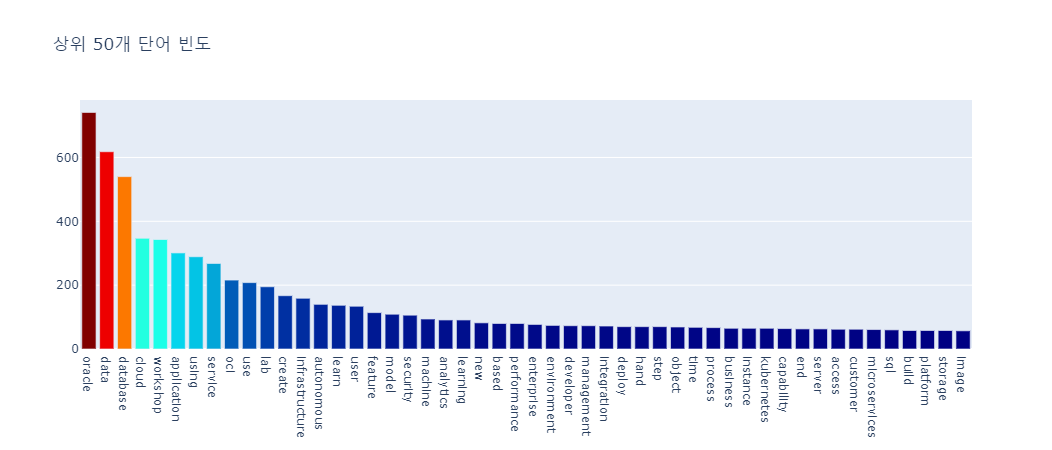

In [39]:
# 상위 50개 단어 빈도에 대한 Plot.ly 플롯 그리기

data = [go.Bar(
            x = x[0:50],
            y = y[0:50],
            marker= dict(colorscale='Jet',
                         color = y[0:50]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='상위 50개 단어 빈도'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

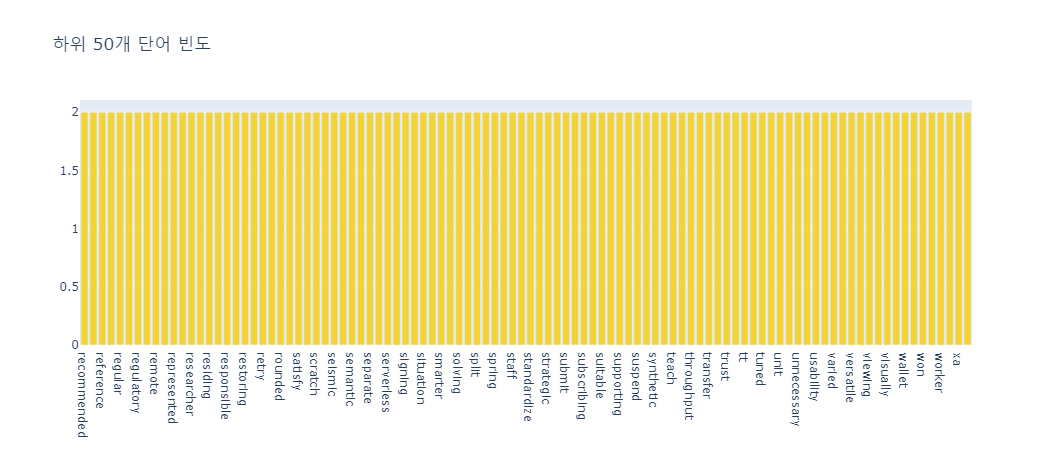

In [40]:
# 하위 50개 단어 빈도에 대한 Plot.ly 플롯 그리기

data = [go.Bar(
            x = x[-100:],
            y = y[-100:],
            marker= dict(colorscale='Portland',
                         color = y[-100:]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='하위 50개 단어 빈도'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

## 3b. Latent Dirichlet Allocation

이 장에서는 '토픽 모델링'을 통해 모델을 구현합니다. 사용할 알고리즘은 [Latent Dirichlet Allocation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)입니다. 

토픽 모델링은 문서들에 잠재되어 있는 공통된 토픽(주제)들을 추출해 내는 기법을 의미합니다. 공통된 유사성을 도출한다는 측면에서 Clustering과 비슷한 기법일 수 있지만 토픽 모델링은 1) 문서들이 가지는 주요 토픽의 분포도와 2) 개별 토픽이 이루는 단어들의 분포를 제공한다는 특징을 가지고 있습니다. 

예를 들어 아래와 같은 문서(Documents)가 있을 때 이 문서의 토픽이 스포츠 주제일 수도 있고 정치 주제일 수도 있습니다. 이런 식으로 한가지 문서가 여러 가지 토픽을 가질 수 있는 것입니다.

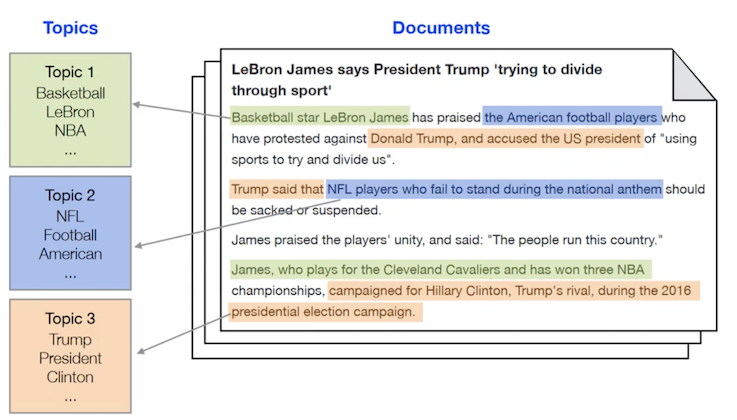

In [41]:
from IPython import display
display.Image("https://blogfiles.pstatic.net/MjAyMjEyMTJfMjYx/MDAxNjcwODQzODA5Mzg4.62Kw5VnRZRMptjF9VMTc8UVYAWd3ox7HTFtG1aySQEYg.3JcZPKcDn7xxGP4HsZF-IKYVpfRpX_ejUX7yKwfD3HYg.PNG.dncks1107/%EB%8B%A4%EC%9A%B4%EB%A1%9C%EB%93%9C.png")

아래와 같이 5개의 문서들이 있을 때 100% Topic A로 구성될 수도 있고 60% Topic A 와 40% Topic B가 혼합돼서 구성될 수도 있습니다. 그리고 각 개별 토픽 중 Topic A가 40% banana, 30% kale, 10% breakfast로 구성 되어 있으면 Topic A는 food에 가까울 것이다라고 판별할 수 있습니다. 

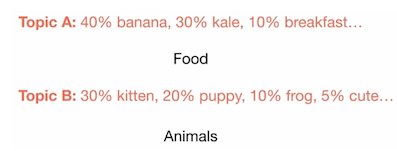

In [42]:
display.Image("https://blogfiles.pstatic.net/MjAyMjEyMTJfMjMw/MDAxNjcwODQzODI2MDIz.pRl9SyDe55PqQ4P7otbHwUros7SJX8EVLHjP9comrjwg.1pAkt3U6YrcFU_2sQbhr8XrWVeJB6BjPbddyHWl3Iq8g.PNG.dncks1107/%EB%8B%A4%EC%9A%B4%EB%A1%9C%EB%93%9C_(1).png")

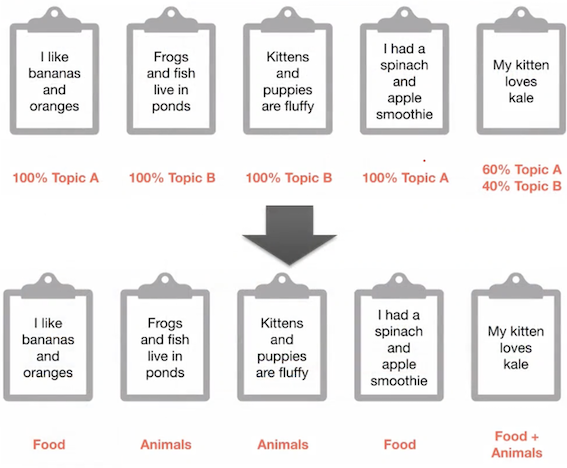

In [43]:
display.Image("https://blogfiles.pstatic.net/MjAyMjEyMTJfMjEx/MDAxNjcwODQzODMzMzQ4.7s-1u5lQmh7ww_Hkk2RNFT5R2tSVY_0ycuiheT3N2uYg.OA-IzWQfHPoMz5sVyuMzIjrOMPSjRjbX_LcxYzVfhQIg.PNG.dncks1107/%EB%8B%A4%EC%9A%B4%EB%A1%9C%EB%93%9C_(2).png")

알고리즘을 호출하기 위해 Sklearn의 *LatentDirichletAllocation* 기능을 통해 LDA 인스턴스를 생성하기만 하면 됩니다. 다양한 매개변수의 값은 default로 몇가지 설정합니다. 

In [44]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=11, max_iter=10,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)
lda.fit(tf)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          n_components=11, random_state=0)

### LDA에서 생성된 주제

"print_top_words" 헬퍼 함수를 활용하여 각 LDA 생성 주제에 귀속된 상위 40개 단어를 반환합니다. 주제 수를 선택하려면 함수의 n_components 매개변수를 통해 처리합니다.

In [45]:
# top words를 출력하는 헬퍼 함수 정의

n_top_words = 40
tf_feature_names = tf_vectorizer.get_feature_names()

def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)
        
print("\nTopics in LDA model: ")

print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:service cloud identity access oracle dr provides data management using workshop iam mysql solution failover resource group server user control cluster purpose instance type primary understand overview component example basic file application model security provider replicate product technical adoption compound

Topic #1:quality data measure rule delivering reference semantic current satisfy poor standardize adapt continually emerging offering ease improve combine innovative fit brings recognition odi creation easy lake requirement identify use include application tool oracle model cloud maintenance solution developer advanced governance

Topic #2:table cluster create partitioning product add access lab data shopping column partition cart hue non big ha using use collection task learn auto apart cloudera bd oracle hadoop sql remove structure customer object application schema partitioned new hdfs quick refactoring

Topic #3:helidon microservices integrat

### 주제의 Word Cloud 시각화

In [46]:
from matplotlib import pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

first_topic = lda.components_[8]
print(first_topic.shape)
print(first_topic)

(1636,)
[0.21130311 0.19162377 0.2106298  ... 0.18667006 0.20020278 0.22031082]


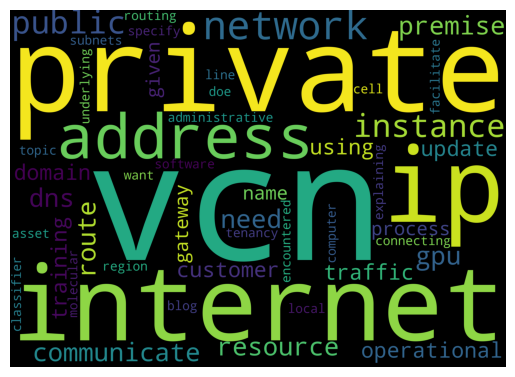

In [47]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
firstcloud = WordCloud(   stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

In [48]:
# 토픽별 문서의 단어 분포

doc_topics=lda.transform(tf)
print(doc_topics.shape)
print(doc_topics[:5])

(474, 11)
[[0.0016529  0.0016529  0.00165308 0.00165303 0.00165311 0.00165292
  0.0016529  0.05569401 0.00165297 0.92942928 0.0016529 ]
 [0.00313482 0.00313485 0.00313517 0.00313492 0.0031353  0.00313482
  0.00313482 0.00313485 0.00313484 0.9686508  0.00313482]
 [0.0031348  0.0031348  0.00313484 0.00313487 0.00313492 0.00313483
  0.0031348  0.00313481 0.0031348  0.96865172 0.0031348 ]
 [0.00144301 0.00144301 0.00144322 0.00144306 0.00144311 0.00144303
  0.00144301 0.00144303 0.00144301 0.98556952 0.00144301]
 [0.0053476  0.0053476  0.00534811 0.00534867 0.00534824 0.00534761
  0.0053476  0.00534761 0.00534787 0.9465215  0.0053476 ]]


총 474개의 행과 11개의 열로 구성되어 있는 array입니다. 여기서 행은 '각 문서들', 열은 '각 토픽들'을 의미합니다. 각 문서들이 실제 무슨 내용으로 구성되어 있는지 살펴봅니다.

In [49]:
#토픽별 단어들의 분포

print(lda.components_.shape)
print(lda.components_)

(11, 1636)
[[0.22152779 0.20404669 0.22291815 ... 0.18757558 0.20104537 0.20768513]
 [0.20929092 0.19667907 0.21866132 ... 0.19996566 0.19244287 0.19533084]
 [0.19124493 0.18893478 0.19674677 ... 0.18335694 0.21394916 0.18650221]
 ...
 [0.21130311 0.19162377 0.2106298  ... 0.18667006 0.20020278 0.22031082]
 [4.16097948 2.61737607 4.96693764 ... 1.81769815 5.10603219 5.92310525]
 [0.18170582 0.19823203 0.18306329 ... 0.18527538 0.19842034 0.19944461]]


shape으로 11개의 행, 1636개의 칼럼으로 이루어진 array를 반환합니다. 여기서 행은 각각의 Topic, 열은 단어를 벡터화시킨 Feature들입니다. 이제 토픽별로 어떤 단어들이 많이 분포하는지 시각적으로 보기 편하게 하도록 함수 하나를 개별적으로 정의합니다.

In [ ]:
topic_index=list(df_final3.index.values)

topic_names = ['Topic #'+str(i) for i in range(0,11)]
topic_df = pd.DataFrame(data=doc_topics, columns=topic_names, index=topic_index)
topic_df

문서를 특정 주제로 분리시키기 위해서는 해당 문서에 가장 많이 확인되는 Topic을 확인하고 할당하는 것입니다. 아래 테이블에서 문서의 모든 주요 주제를 녹색으로 표시하고 자체 열에 가장 지배적인 주제를 할당했습니다.

In [51]:
# 각 문서에 대한 주요 topic 가져오기

dominant_topic = np.argmax(topic_df.values, axis=1)
topic_df['dominant_topic'] = dominant_topic

# Styling

def color_green(val):
 color = 'green' if val > .1 else 'black'
 return 'color : {col}'.format(col=color)

def make_bold(val):
 weight = 700 if val > .1 else 400
 return 'font-weight: {weight}'.format(weight=weight)

# Apply Style

df_document_topics = topic_df.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic #0,Topic #1,Topic #2,Topic #3,Topic #4,Topic #5,Topic #6,Topic #7,Topic #8,Topic #9,Topic #10,dominant_topic
0,0.001653,0.001653,0.001653,0.001653,0.001653,0.001653,0.001653,0.055694,0.001653,0.929429,0.001653,9
1,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.968651,0.003135,9
2,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.968652,0.003135,9
3,0.001443,0.001443,0.001443,0.001443,0.001443,0.001443,0.001443,0.001443,0.001443,0.985570,0.001443,9
4,0.005348,0.005348,0.005348,0.005349,0.005348,0.005348,0.005348,0.005348,0.005348,0.946521,0.005348,9
5,0.002217,0.002217,0.687588,0.002217,0.002217,0.002217,0.002217,0.002217,0.002217,0.292456,0.002217,2
6,0.002165,0.002165,0.002165,0.002165,0.002165,0.028282,0.002165,0.002165,0.002165,0.952237,0.002165,9
7,0.002841,0.002841,0.002841,0.002841,0.002841,0.002841,0.002841,0.002841,0.002841,0.971590,0.002841,9
8,0.004785,0.004785,0.004785,0.004785,0.004786,0.004785,0.004785,0.004785,0.004785,0.952151,0.004785,9
9,0.002674,0.002674,0.002674,0.002674,0.002674,0.002674,0.002674,0.002674,0.002674,0.973262,0.002674,9


In [52]:
df_document_topics = topic_df.style.applymap(color_green).applymap(make_bold)
topic_data = df_document_topics.data
type(topic_data)

pandas.core.frame.DataFrame

위 구현된 lda 모델을 사용해서 sample 문구를 입력하여 sample 문구에 해당되는 Topic을 할당해보겠습니다. 

In [53]:
sample = ["I want to know about private subnet and VCN"]
# sample = ["kubernetes and oke"]

In [54]:
sample_vec = tf_vectorizer.transform(sample)

In [55]:
topic_probability_scores = lda.transform(sample_vec)

In [56]:
topic_probability_scores 

array([[0.01818193, 0.01818189, 0.01818188, 0.01818185, 0.01818189,
        0.01818189, 0.01818193, 0.01818188, 0.58654319, 0.24981977,
        0.0181819 ]])

In [57]:
topic_chosen = np.argmax(topic_probability_scores)
print(topic_chosen)

8


In [58]:
topic_data.loc[topic_data['dominant_topic']==topic_chosen]

,Topic #0,Topic #1,Topic #2,Topic #3,Topic #4,Topic #5,Topic #6,Topic #7,Topic #8,Topic #9,Topic #10,dominant_topic
28,0.002933,0.002933,0.002933,0.002933,0.002933,0.002933,0.002933,0.002933,0.970674,0.002933,0.002933,8
49,0.001894,0.001894,0.001894,0.001894,0.001894,0.001894,0.001894,0.001894,0.560874,0.422081,0.001894,8
162,0.005051,0.005051,0.005051,0.005051,0.005051,0.005051,0.005051,0.005051,0.949492,0.005053,0.005051,8


In [59]:
indices = topic_data.index[topic_data['dominant_topic'] == topic_chosen]
print(indices)

for index in indices:
    print(crawled_parquet_df.loc[index])

Int64Index([28, 49, 162], dtype='int64')
id                                                            621
title                     Configure Virtual Cloud Network Peering
url             https://apexapps.oracle.com/pls/apex/r/dbpm/li...
type                                                     Hands-on
desc            Local VCN peering is the process of connecting...
duration                                                  2 hours
crawled_time                                  2023-03-07 07:22:53
title_ko                                      가상 클라우드 네트워크 피어링 구성
desc_ko         로컬 VCN 피어링은 인터넷 또는 온프레미스 네트워크를 통해 트래픽을 라우팅하지 않...
duration_ko                                                   2시간
oci_products                                      [internet, vcn]
key_phrase      [vcn, two vcns, same region and tenancy, priva...
Name: 28, dtype: object
id                                                            654
title           Configuring NAT Gateway for Private Compute In...
url        

---

# 4. KMeans Clustering

이 장에서는 Livelab별 군집을 형성할 것입니다.

위 **Latent Dirichlet Allocation**에서 각 Topic별 할당된 Probability를 feature로 cluster를 형성합니다. 위 dominant topic과 cluster과의 관계도 비교해봅니다.

In [60]:
topic_df.head()

,Topic #0,Topic #1,Topic #2,Topic #3,Topic #4,Topic #5,Topic #6,Topic #7,Topic #8,Topic #9,Topic #10,dominant_topic
0,0.001653,0.001653,0.001653,0.001653,0.001653,0.001653,0.001653,0.055694,0.001653,0.929429,0.001653,9
1,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.968651,0.003135,9
2,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.968652,0.003135,9
3,0.001443,0.001443,0.001443,0.001443,0.001443,0.001443,0.001443,0.001443,0.001443,0.985570,0.001443,9
4,0.005348,0.005348,0.005348,0.005349,0.005348,0.005348,0.005348,0.005348,0.005348,0.946521,0.005348,9


In [61]:
X=topic_df.drop(['dominant_topic'],axis=1)
y=topic_df['dominant_topic']

In [ ]:
from sklearn.cluster import KMeans

# Perform clustering
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit_predict(X)

# Add cluster labels to the topic_df
topic_df['cluster'] = clusters

# Display data for each cluster
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
for cluster_id in range(5):
    print(f"Cluster {cluster_id}:")
    cluster_data = topic_df[topic_df['cluster'] == cluster_id]
    print(cluster_data)
    print()

---

# 번외1. kNN Classifier

K-means 알고리즘은 K-NN 알고리즘과 유사하면서도 다르다. 둘은 모두 K개의 점을 지정하여 거리를 기반으로 구현되는 거리기반 분석 알고리즘이다. 하지만 둘의 차이점은 지도학습에 속하는 K-NN 알고리즘과 달리 K-means 알고리즘은 비지도학습 방법에 속한다. 따라서 K-means 알고리즘의 목적을 분류(Classification)라고 하지 않고 군집화(Clustering)라고 한다. 즉, K-NN은 분류 알고리즘, K-means은 군집화 알고리즘이라고 할 수 있다.

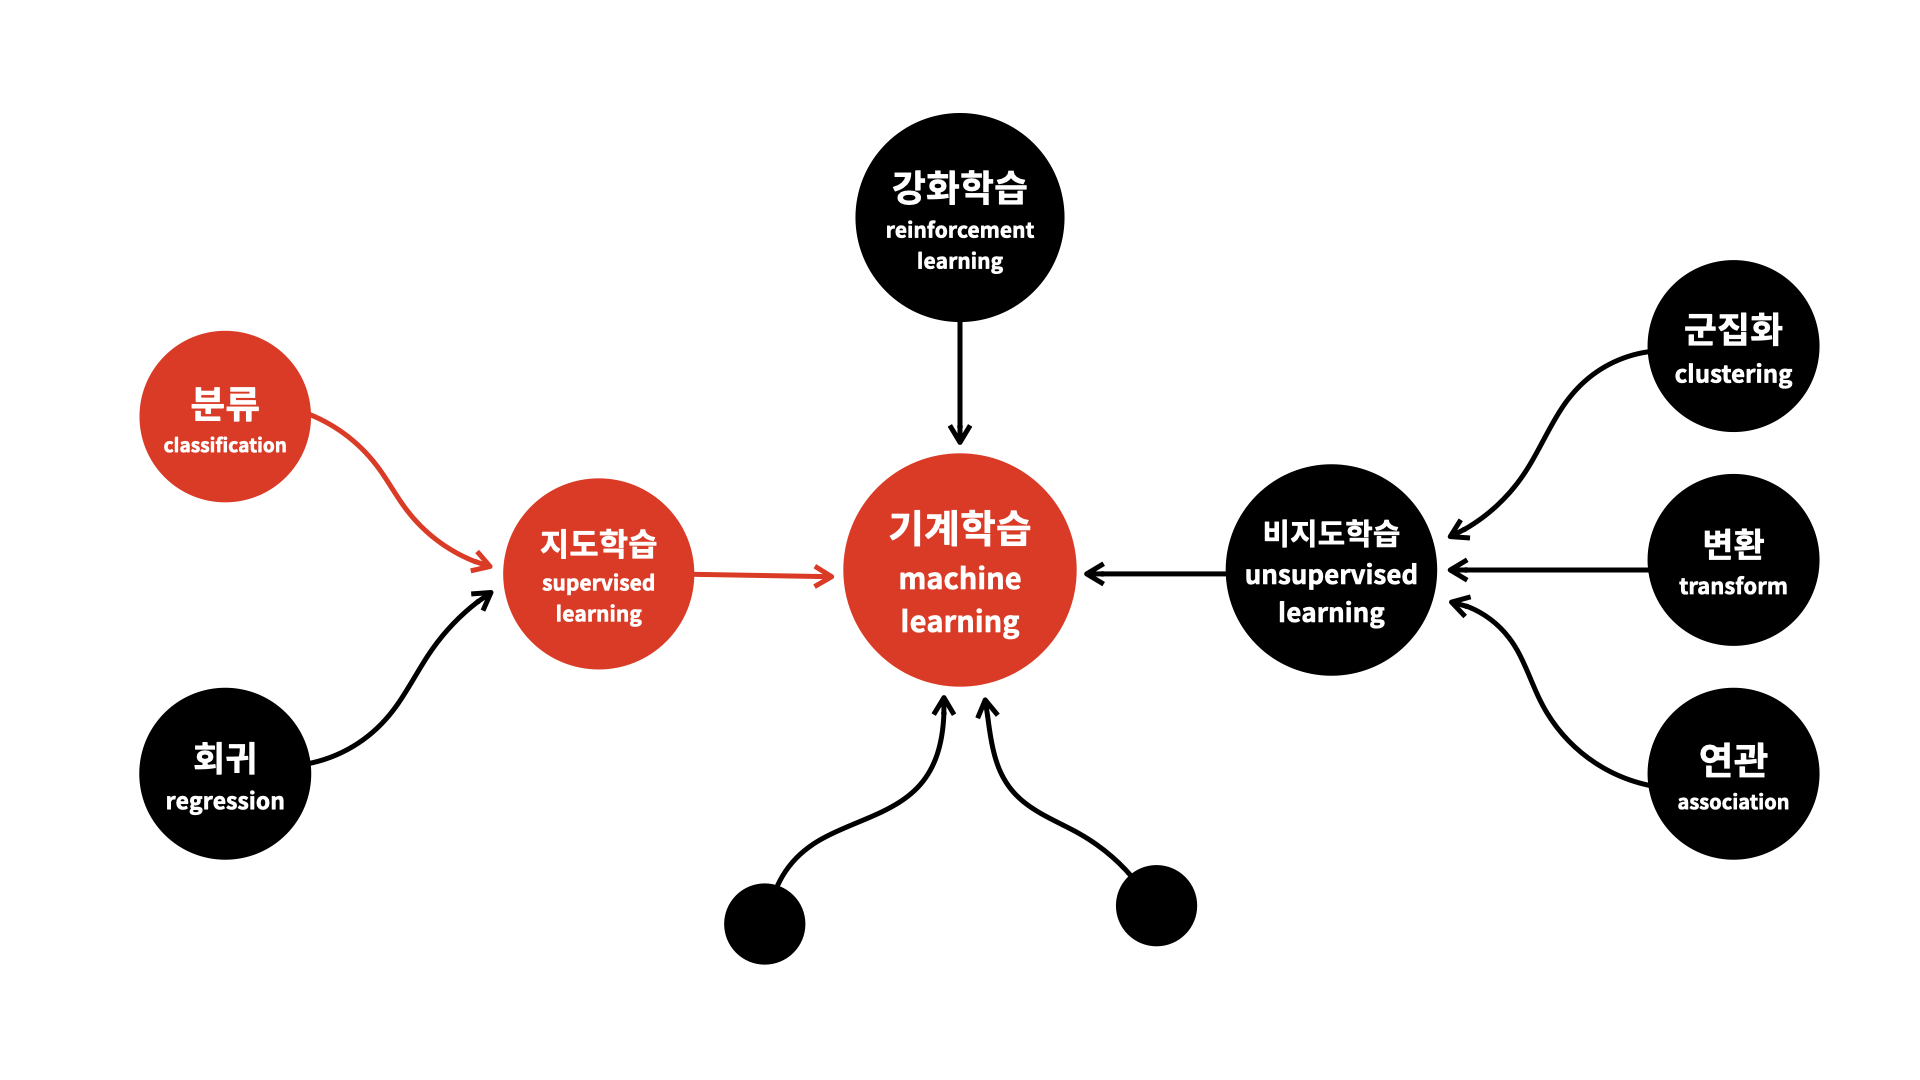

In [66]:
from IPython import display
display.Image("https://s3-ap-northeast-2.amazonaws.com/opentutorials-user-file/module/4916/12316.jpeg")

In [67]:
topic_df.head()

,Topic #0,Topic #1,Topic #2,Topic #3,Topic #4,Topic #5,Topic #6,Topic #7,Topic #8,Topic #9,Topic #10,dominant_topic,cluster
0,0.001653,0.001653,0.001653,0.001653,0.001653,0.001653,0.001653,0.055694,0.001653,0.929429,0.001653,9,1
1,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.968651,0.003135,9,1
2,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.968652,0.003135,9,1
3,0.001443,0.001443,0.001443,0.001443,0.001443,0.001443,0.001443,0.001443,0.001443,0.985570,0.001443,9,1
4,0.005348,0.005348,0.005348,0.005349,0.005348,0.005348,0.005348,0.005348,0.005348,0.946521,0.005348,9,1


In [68]:
X=topic_df.drop(['dominant_topic'],axis=1)
y=topic_df['dominant_topic']

#importing train_test_split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=42, stratify=y)

In [69]:
from sklearn.neighbors import KNeighborsClassifier

test_scores = []
train_scores = []

for i in range(1,15):

    knn = KNeighborsClassifier(i)
    knn.fit(X_train,y_train)
    
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

In [70]:
import seaborn as sns
sns.set()

plt.figure(figsize=(12,5))

p = sns.lineplot(range(1,15),train_scores,marker='*',label='Train Score')
p = sns.lineplot(range(1,15),test_scores,marker='o',label='Test Score')

ERROR - Exception
Traceback (most recent call last):
  File "/home/datascience/conda/generalmachinelearningforcpusonpython3_8v1_0/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_22689/3454806691.py", line 6, in <module>
    p = sns.lineplot(range(1,15),train_scores,marker='*',label='Train Score')
TypeError: lineplot() takes from 0 to 1 positional arguments but 2 were given
TypeError: lineplot() takes from 0 to 1 positional arguments but 2 were given

<Figure size 1200x500 with 0 Axes>

In [71]:
#Setup a knn classifier with 4 neighbors
knn = KNeighborsClassifier(4)

knn.fit(X_train,y_train)
knn.score(X_test,y_test)

0.9810126582278481

Text(0.5, 19.049999999999997, 'Predicted label')

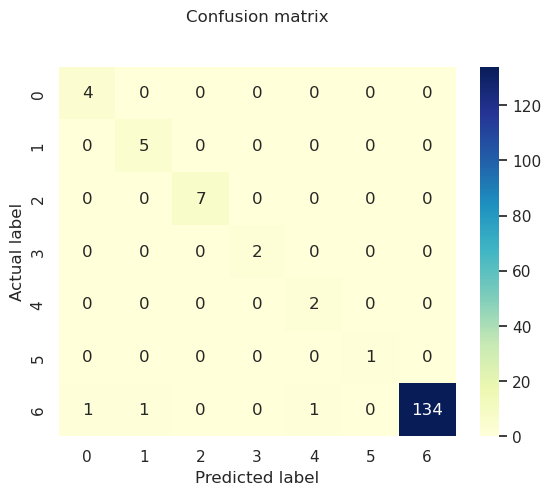

In [72]:
y_pred = knn.predict(X_test)

from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [73]:
print(y_pred)

[9 9 4 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 9 7 4 9 9
 9 9 9 9 9 4 9 9 9 4 9 9 5 9 9 9 3 9 9 2 3 9 9 9 9 9 9 2 9 4 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 4 9 2 9 9 9 9 9 9 9 3 8 7 9 9 9 2 9 9 9 9 9 9 9
 9 9 2 3 4 9 9 9 9 9 9 9 9 9 9 9 9 9 9 3 9 9 9 5 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9]


In [74]:
X.head()

,Topic #0,Topic #1,Topic #2,Topic #3,Topic #4,Topic #5,Topic #6,Topic #7,Topic #8,Topic #9,Topic #10,cluster
0,0.001653,0.001653,0.001653,0.001653,0.001653,0.001653,0.001653,0.055694,0.001653,0.929429,0.001653,1
1,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.968651,0.003135,1
2,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.968652,0.003135,1
3,0.001443,0.001443,0.001443,0.001443,0.001443,0.001443,0.001443,0.001443,0.001443,0.985570,0.001443,1
4,0.005348,0.005348,0.005348,0.005349,0.005348,0.005348,0.005348,0.005348,0.005348,0.946521,0.005348,1


In [75]:
# 예측 결과를 데이터프레임으로 변환
y_result = knn.predict(X)
y_result2 = pd.DataFrame(y_result, columns=['Predicted_Label'])
y_result2.head()

,Predicted_Label
0,9
1,9
2,9
3,9
4,9


In [76]:
# 기존 데이터와 예측 결과를 열 방향(axis=1)으로 병합
data_with_predictions = pd.concat([topic_df, y_result2], axis=1)

# NaN 값을 가진 행 제거
data_with_predictions = data_with_predictions.dropna()

data_with_predictions.head()

,Topic #0,Topic #1,Topic #2,Topic #3,Topic #4,Topic #5,Topic #6,Topic #7,Topic #8,Topic #9,Topic #10,dominant_topic,cluster,Predicted_Label
0,0.001653,0.001653,0.001653,0.001653,0.001653,0.001653,0.001653,0.055694,0.001653,0.929429,0.001653,9.0,1.0,9.0
1,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.968651,0.003135,9.0,1.0,9.0
2,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.003135,0.968652,0.003135,9.0,1.0,9.0
3,0.001443,0.001443,0.001443,0.001443,0.001443,0.001443,0.001443,0.001443,0.001443,0.985570,0.001443,9.0,1.0,9.0
4,0.005348,0.005348,0.005348,0.005349,0.005348,0.005348,0.005348,0.005348,0.005348,0.946521,0.005348,9.0,1.0,9.0


In [77]:
data_with_predictions.dtypes
data_with_predictions = data_with_predictions.astype({"dominant_topic":'int', "cluster":'int', "Predicted_Label":'int'}) 

In [78]:
# 결과 확인
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
print(data_with_predictions)

     Topic #0  Topic #1  Topic #2  Topic #3  Topic #4  Topic #5  Topic #6  Topic #7  Topic #8  Topic #9  Topic #10  dominant_topic  cluster  Predicted_Label
0    0.001653  0.001653  0.001653  0.001653  0.001653  0.001653  0.001653  0.055694  0.001653  0.929429  0.001653   9               1        9              
1    0.003135  0.003135  0.003135  0.003135  0.003135  0.003135  0.003135  0.003135  0.003135  0.968651  0.003135   9               1        9              
2    0.003135  0.003135  0.003135  0.003135  0.003135  0.003135  0.003135  0.003135  0.003135  0.968652  0.003135   9               1        9              
3    0.001443  0.001443  0.001443  0.001443  0.001443  0.001443  0.001443  0.001443  0.001443  0.985570  0.001443   9               1        9              
4    0.005348  0.005348  0.005348  0.005349  0.005348  0.005348  0.005348  0.005348  0.005348  0.946521  0.005348   9               1        9              
5    0.002217  0.002217  0.687588  0.002217  0.002217  0.0

---

# 번외2. LDA & K-Means & KNN 최종 결과

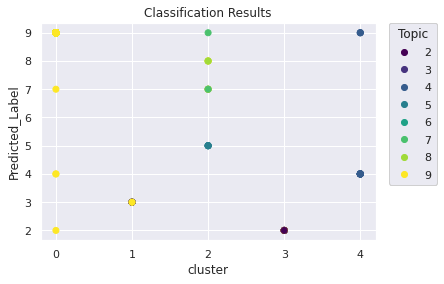

In [80]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

scatter = ax.scatter(data_with_predictions['cluster'], data_with_predictions['Predicted_Label'], c=data_with_predictions['dominant_topic'], cmap='viridis')

legend1=plt.legend(*scatter.legend_elements(num=6),bbox_to_anchor=(1.04, 1), borderaxespad=0, title="Topic")

ax.add_artist(legend1)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.title('Classification Results')
plt.xlabel('cluster')
plt.ylabel('Predicted_Label')

plt.show()